### 데이터 불러오고 이전 데이터 추정

In [205]:
# 매크로 데이터 불러오기
import pandas as pd

macro = pd.read_csv("macro.csv", index_col = 0)
macro["date"] = pd.to_datetime(macro["date"])
macro.head()

,date,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2005-02-01,47.12,12.03,0.736,9.9161,1028.50,56.8,54.7
1,2005-02-02,46.69,11.66,0.706,9.9151,1027.85,56.8,54.7
2,2005-02-03,46.45,11.79,0.697,9.8172,1025.50,56.8,54.7
3,2005-02-04,46.48,11.21,0.661,9.8319,1023.50,56.8,54.7
4,2005-02-07,45.28,11.73,0.627,9.8169,1029.50,56.8,54.7


In [206]:
# ETF 데이터
import FinanceDataReader as fdr

kosdaq150_etf = fdr.DataReader("232080", "2010-01-01")
kosdaq150_etf = kosdaq150_etf.reset_index()
kosdaq150_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
kosdaq150_etf.head()

,date,open,high,low,close,volume,change
0,2015-11-12,10228,10303,10219,10243,251076,NaN
1,2015-11-13,10166,10262,10131,10268,302337,0.002441
2,2015-11-16,10088,10180,10048,10125,378486,-0.013927
3,2015-11-17,10298,10298,10228,10278,371273,0.015111
4,2015-11-18,10382,10387,10308,10317,368548,0.003795


In [207]:
# kosdaq150 데이터

kosdaq150 = fdr.DataReader("KQ11", "2010-01-01")
kosdaq150 = kosdaq150.reset_index()
kosdaq150.columns = ["date", "close", "open", "high", "low", "volume", "change"]
kosdaq150["high_change"] = (kosdaq150["high"] / kosdaq150["close"]) - 1
kosdaq150["low_change"] = (kosdaq150["low"] / kosdaq150["close"]) - 1
kosdaq150.head()

,date,close,open,high,low,volume,change,high_change,low_change
0,2010-01-04,528.09,517.03,528.10,517.03,666850.0,0.0283,0.000019,-0.020943
1,2010-01-05,533.09,533.43,536.65,531.06,886820.0,0.0095,0.006678,-0.003808
2,2010-01-06,539.12,537.10,539.13,532.54,1130000.0,0.0113,0.000019,-0.012205
3,2010-01-07,535.52,542.88,545.42,534.63,1180000.0,-0.0067,0.018487,-0.001662
4,2010-01-08,538.96,539.63,540.29,529.67,893030.0,0.0064,0.002468,-0.017237


In [208]:
# 2015년 11월 12일 이전 데이터 추정
use_kosdaq150 = kosdaq150[kosdaq150["date"] <= "2015-11-12"].sort_values(by = "date", ascending = False).reset_index(drop = True)

kosdaq150_list = [10243]
for i in range(0, len(use_kosdaq150)):
    estimate = kosdaq150_list[-1] / (1 + use_kosdaq150["change"][i])
    kosdaq150_list.append(estimate)

kosdaq150_list = kosdaq150_list[:1456]

low_list = []
high_list = []
for j in range(1, len(kosdaq150_list)):
    low_estimation = kosdaq150_list[j] * (1 + use_kosdaq150["low_change"][j])
    high_estimation = kosdaq150_list[j] * (1 + use_kosdaq150["high_change"][j])

    low_list.append(low_estimation)
    high_list.append(high_estimation)

In [209]:
# 추정 데이터와 ETF 데이터 합치기
df_estimation = pd.DataFrame()
df_estimation["date"] = use_kosdaq150["date"][1:]
df_estimation["high"] = high_list
df_estimation["low"] = low_list
df_estimation["close"] = kosdaq150_list[1:]

df_estimation = df_estimation.sort_values(by = "date", ascending = True).reset_index(drop = True)

kosdaq150_etf = pd.concat([df_estimation, kosdaq150_etf], axis = 0).reset_index(drop = True)
kosdaq150_etf.head()

,date,high,low,close,open,volume,change
0,2010-01-04,8038.206507,7869.710112,8038.054297,NaN,NaN,NaN
1,2010-01-05,8168.604262,8083.516220,8114.415813,NaN,NaN,NaN
2,2010-01-06,8206.260925,8105.952540,8206.108712,NaN,NaN,NaN
3,2010-01-07,8301.815274,8137.581130,8151.127783,NaN,NaN,NaN
4,2010-01-08,8223.538400,8061.895620,8203.295001,NaN,NaN,NaN


### 기술 지표 데이터 산출

In [210]:
# true range

high_low = []
high_close = []
low_close = []

for i in range(0, len(kosdaq150_etf)):
    
    # |당일 고가 - 당일 저가|
    today_high = kosdaq150_etf["high"][i]
    today_low = kosdaq150_etf["low"][i]
    val_high_low = abs(today_high - today_low)
    high_low.append(val_high_low)
    
    # |당일 고가 - 전일 종가|
    if i - 1 == -1:
        recent_close = kosdaq150_etf["close"][i]
    
    else:
        recent_close = kosdaq150_etf["close"][i - 1]
        
    val_high_close = abs(today_high - recent_close)
    high_close.append(val_high_close)
    
    # |당일 저가 - 전일 종가|
    val_low_close = abs(today_low - recent_close)
    low_close.append(val_low_close)
    
true_range = []

for j in range(0, len(kosdaq150_etf)):
    tr_val = max(high_low[j], high_close[j], low_close[j])
    true_range.append(tr_val)
    
kosdaq150_etf["true_range"] = true_range

In [211]:
# nomalized average true range
import numpy as np

natr = []

for i in range(0, len(kosdaq150_etf)):
    if i + 1 < 14:
        natr_val = np.nan
    
    else:
        natr_val = kosdaq150_etf["true_range"][i-13:i+1].sum() / kosdaq150_etf["close"][i] * 100
        
    natr.append(natr_val)
    
kosdaq150_etf["NATR"] = natr

In [212]:
# moving average (5, 15, 30)

ma5 = []

for i in range(0, len(kosdaq150_etf)):
    if i + 1 < 5:
        ma5_val = np.nan
        
    else:
        ma5_val = kosdaq150_etf["close"][i-4:i+1].sum() / 5
        
    ma5.append(ma5_val)
    
ma15 = []

for j in range(0, len(kosdaq150_etf)):
    if j + 1 < 15:
        ma15_val = np.nan
        
    else:
        ma15_val = kosdaq150_etf["close"][j-14:j+1].sum() / 15
        
    ma15.append(ma15_val)
    
ma30 = []

for k in range(0, len(kosdaq150_etf)):
    if k + 1 < 30:
        ma30_val = np.nan
        
    else:
        ma30_val = kosdaq150_etf["close"][k-29:k+1].sum() / 30
        
    ma30.append(ma30_val)
    
kosdaq150_etf["MA5"] = ma5
kosdaq150_etf["MA15"] = ma15
kosdaq150_etf["MA30"] = ma30

In [213]:
# bollinger band (upper, middle, lower band, band width)

middle_band = []

for i in range(0, len(kosdaq150_etf)):
    if i + 1 < 20:
        middle = np.nan
        
    else:
        middle = kosdaq150_etf["close"][i-19:i+1].sum() / 20
        
    middle_band.append(middle)
    
upper_band = []
lower_band = []

for j in range(0, len(kosdaq150_etf)):
    if j + 1 < 20:
        upper = np.nan
        lower = np.nan
        
    else:
        upper = middle_band[j] + (2 * kosdaq150_etf["close"][j-19:j+1].std())
        lower = middle_band[j] - (2 * kosdaq150_etf["close"][j-19:j+1].std())
        
    upper_band.append(upper)
    lower_band.append(lower)
    
kosdaq150_etf["upper_band"] = upper_band
kosdaq150_etf["middle_band"] = middle_band
kosdaq150_etf["lower_band"] = lower_band
kosdaq150_etf["band_width"] = kosdaq150_etf["upper_band"] - kosdaq150_etf["lower_band"]

In [214]:
# on balance volume

obv = []

for i in range(0, len(kosdaq150_etf)):
    if i - 1 == -1:
        obv_val = kosdaq150_etf["volume"][i]
        
    else:
        if kosdaq150_etf["close"][i] > kosdaq150_etf["close"][i-1]:
            obv_val = obv_val + kosdaq150_etf["volume"][i]
        
        else:
            obv_val = obv_val - kosdaq150_etf["volume"][i]
            
    obv.append(obv_val)
    
kosdaq150_etf["OBV"] = obv

In [215]:
# 5 days momentun, 20 days momentum (영업일 기준)
kosdaq150_etf["close_5lag"] = kosdaq150_etf["close"].shift(5)
kosdaq150_etf["momentum_5"] = (kosdaq150_etf["close"] - kosdaq150_etf["close_5lag"]) / kosdaq150_etf["close_5lag"]

kosdaq150_etf["close_20lag"] = kosdaq150_etf["close"].shift(20)
kosdaq150_etf["momentum_20"] = (kosdaq150_etf["close"] - kosdaq150_etf["close_20lag"]) / kosdaq150_etf["close_20lag"]

In [216]:
# target 생성
def target(x):
    if x > 0:
        return 1
    
    elif x <= 0:
        return 0
    
kosdaq150_etf["close_-20lag"] = kosdaq150_etf["close"].shift(-20)
kosdaq150_etf["return"] = (kosdaq150_etf["close_-20lag"] - kosdaq150_etf["close"]) / kosdaq150_etf["close"]
kosdaq150_etf["grade"] = kosdaq150_etf["return"].apply(target)

kosdaq150_etf.head()

,date,high,low,close,open,volume,change,true_range,NATR,MA5,...,lower_band,band_width,OBV,close_5lag,momentum_5,close_20lag,momentum_20,close_-20lag,return,grade
0,2010-01-04,8038.206507,7869.710112,8038.054297,NaN,NaN,NaN,168.496395,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7640.642390,-0.049441,0.0
1,2010-01-05,8168.604262,8083.516220,8114.415813,NaN,NaN,NaN,130.549965,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7681.901859,-0.053302,0.0
2,2010-01-06,8206.260925,8105.952540,8206.108712,NaN,NaN,NaN,100.308385,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7843.989988,-0.044128,0.0
3,2010-01-07,8301.815274,8137.581130,8151.127783,NaN,NaN,NaN,164.234144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7858.109170,-0.035948,0.0
4,2010-01-08,8223.538400,8061.895620,8203.295001,NaN,NaN,NaN,161.642780,NaN,8142.600321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7571.288185,-0.077043,0.0


In [217]:
# kosdaq150_etf과 macro date merge
kosdaq150_etf = pd.merge(kosdaq150_etf, macro, on = "date", how = "inner").reset_index(drop = True)
kosdaq150_etf.head()

,date,high,low,close,open,volume,change,true_range,NATR,MA5,...,close_-20lag,return,grade,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2010-01-04,8038.206507,7869.710112,8038.054297,NaN,NaN,NaN,168.496395,NaN,NaN,...,7640.642390,-0.049441,0.0,81.51,20.04,2.204,12.4230,1150.00,55.9,56.6
1,2010-01-05,8168.604262,8083.516220,8114.415813,NaN,NaN,NaN,130.549965,NaN,NaN,...,7681.901859,-0.053302,0.0,81.77,19.35,2.212,12.4313,1140.20,55.9,56.6
2,2010-01-06,8206.260925,8105.952540,8206.108712,NaN,NaN,NaN,100.308385,NaN,NaN,...,7843.989988,-0.044128,0.0,83.18,19.16,2.273,12.2274,1129.20,55.9,56.6
3,2010-01-07,8301.815274,8137.581130,8151.127783,NaN,NaN,NaN,164.234144,NaN,NaN,...,7858.109170,-0.035948,0.0,82.66,19.06,2.243,12.1974,1138.20,55.9,56.6
4,2010-01-08,8223.538400,8061.895620,8203.295001,NaN,NaN,NaN,161.642780,NaN,8142.600321,...,7571.288185,-0.077043,0.0,82.75,18.13,2.294,12.1710,1128.25,55.9,56.6


In [218]:
# 필요한 칼럼만 추출
kosdaq_etf = kosdaq150_etf[["date", "volume", "NATR", "momentum_5", "momentum_20", "wti", "diff", "ism", "vix", "jpy_krw", "usd_krw", "china_pmi", "grade"]]
kosdaq_etf.head()

,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-01-04,NaN,NaN,NaN,NaN,81.51,2.204,55.9,20.04,12.4230,1150.00,56.6,0.0
1,2010-01-05,NaN,NaN,NaN,NaN,81.77,2.212,55.9,19.35,12.4313,1140.20,56.6,0.0
2,2010-01-06,NaN,NaN,NaN,NaN,83.18,2.273,55.9,19.16,12.2274,1129.20,56.6,0.0
3,2010-01-07,NaN,NaN,NaN,NaN,82.66,2.243,55.9,19.06,12.1974,1138.20,56.6,0.0
4,2010-01-08,NaN,NaN,NaN,NaN,82.75,2.294,55.9,18.13,12.1710,1128.25,56.6,0.0


In [219]:
# volume 결측값을 0으로 채우기
kosdaq_etf["volume"] = kosdaq_etf["volume"].replace(np.nan, 0)
kosdaq_etf.head()

<ipython-input-219-f383fc601964>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kosdaq_etf["volume"] = kosdaq_etf["volume"].replace(np.nan, 0)


,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-01-04,0.0,NaN,NaN,NaN,81.51,2.204,55.9,20.04,12.4230,1150.00,56.6,0.0
1,2010-01-05,0.0,NaN,NaN,NaN,81.77,2.212,55.9,19.35,12.4313,1140.20,56.6,0.0
2,2010-01-06,0.0,NaN,NaN,NaN,83.18,2.273,55.9,19.16,12.2274,1129.20,56.6,0.0
3,2010-01-07,0.0,NaN,NaN,NaN,82.66,2.243,55.9,19.06,12.1974,1138.20,56.6,0.0
4,2010-01-08,0.0,NaN,NaN,NaN,82.75,2.294,55.9,18.13,12.1710,1128.25,56.6,0.0


In [220]:
# 결측치 제거
kosdaq_etf = kosdaq_etf.dropna(axis = 0).reset_index(drop = True)
kosdaq_etf.head()

,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-02-01,0.0,32.432913,-0.060320,-0.049441,74.43,2.265,58.4,22.59,12.8662,1166.25,55.8,1.0
1,2010-02-02,0.0,33.362482,-0.033301,-0.053302,77.23,2.257,58.4,21.48,12.8361,1160.00,55.8,1.0
2,2010-02-03,0.0,33.214905,-0.002127,-0.044128,76.98,2.294,58.4,21.60,12.6252,1148.70,55.8,0.0
3,2010-02-04,0.0,32.377224,-0.002227,-0.035948,73.14,2.297,58.4,26.08,12.8880,1146.90,55.8,1.0
4,2010-02-05,0.0,37.442388,0.001724,-0.077043,71.19,2.310,58.4,26.11,13.0940,1169.95,55.8,1.0


### 머신러닝으로 테스트

In [221]:
# train, test set 분리
train = kosdaq_etf[kosdaq_etf["date"] < "2018-01-01"].reset_index(drop = True)
test = kosdaq_etf[kosdaq_etf["date"] >= "2018-01-01"].reset_index(drop = True)

train.shape, test.shape

((1894, 13), (741, 13))

In [222]:
# 필요없는 칼럼 제거
drop_col = ["date"]

train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)

In [223]:
# baseline
print(train["grade"].value_counts(normalize = True))
print("-------")
print(test["grade"].value_counts(normalize = True))

1.0    0.552798
0.0    0.447202
Name: grade, dtype: float64
-------
0.0    0.508772
1.0    0.491228
Name: grade, dtype: float64


In [224]:
# feature, target 분리
target = "grade"

X_train = train.drop(target, axis = 1)
y_train = train[target]

X_test = test.drop(target, axis = 1)
y_test = test[target]

In [28]:
# 하이퍼 파라미터를 최적화한 XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipe = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(random_state = 99)
)

params = {
    "xgbclassifier__scale_pos_weight" : [0.586298 / 0.413702, 1, 0.413702 / 0.586298],
    "xgbclassifier__max_depth" : [5, 10, 15, 20, 25],
    "xgbclassifier__min_child_weight" : [10, 15, 20, 25, 30],
    "xgbclassifier__learning_rate" : [0.001, 0.005, 0.01, 0.05],
    "xgbclassifier__subsample" : [0.3, 0.4, 0.5],
    "xgbclassifier__n_estimators" : [500, 1000],
    "xgbclassifier__gamma" : [0.25, 0.5, 0.7, 1.0]
}

clf = RandomizedSearchCV(
    pipe,
    params,
    n_iter = 100,
    cv = 5,
    scoring = "f1_weighted",
    verbose = 1,
    n_jobs = -1,
    random_state = 99
)

clf.fit(X_train, y_train)

In [136]:
# 최적 하이퍼 파라미터 / CV score
print("최적 하이퍼파라미터: ", clf.best_params_, "\n")
print("CV accuracy score: ", clf.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 1.5546960422648912, 'xgbclassifier__n_estimators': 500, 'xgbclassifier__min_child_weight': 25, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__gamma': 1.0} 

CV accuracy score:  0.6043403695506592


In [ ]:
["volume", "true_range", "NATR", "band_width", "OBV", "momentum_5", "momentum_20"]
[["volume", "NATR", "momentum_5", "momentum_20", "wti", "diff", "ism", "vix", "jpy_krw", "usd_krw", "china_pmi"]]

In [225]:
# 최적 하이퍼 파라미터를 적용한 모델의 train, test set 정확도
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

pipe_opt = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(n_estimators = 1000, max_depth = 9, min_child_weight = 18, subsample = 0.71,
                  learning_rate = 0.0001, gamma = 0.3, scale_pos_weight = 0.447202 / 0.552798, random_state = 99, n_jobs = -1)
)

pipe_opt.fit(X_train, y_train)

print("Train set accuracy score: ", pipe_opt.score(X_train, y_train))
print("Test set accuracy score: ", pipe_opt.score(X_test, y_test))

Train set accuracy score:  0.793558606124604
Test set accuracy score:  0.5344129554655871


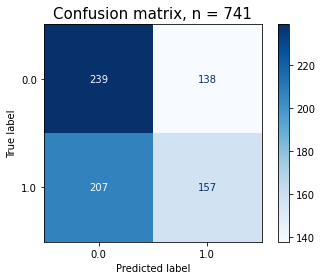

In [226]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

flg, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_opt, X_test, y_test,
                           cmap = plt.cm.Blues,
                           ax = ax);

plt.title(f"Confusion matrix, n = {len(y_test)}", fontsize = 15)
plt.show()

In [227]:
pipe_opt.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [228]:
def vaa_score(df):
    df["close_1y_lag"] = df["close"].shift(252)
    df["close_6m_lag"] = df["close"].shift(121)
    df["close_3m_lag"] = df["close"].shift(60)
    
    df["momentum_1y"] = (df["close"] - df["close_1y_lag"]) - 1
    df["momentum_6m"] = (df["close"] - df["close_6m_lag"]) - 1
    df["momentum_3m"] = (df["close"] - df["close_3m_lag"]) - 1
    
    df["vaa_score"] = (12 * df["momentum_20"]) + (4 * df["momentum_3m"]) + (2 * df["momentum_6m"]) + (1 * df["momentum_1y"])
    
    return df

In [230]:
kosdaq150_vaa = vaa_score(kosdaq150_etf)

In [231]:
kosdaq150_result = kosdaq150_vaa[kosdaq150_vaa["date"] >= "2018-01-01"][["date", "change", "vaa_score"]].reset_index(drop = True)
kosdaq150_result = pd.merge(kosdaq150_result, kosdaq_etf["date"], on = "date", how = "inner")
kosdaq150_result["predict"] = pipe_opt.predict(X_test)
kosdaq150_result

,date,change,vaa_score,predict
0,2018-01-02,0.016481,28524.824455,1.0
1,2018-01-03,0.016072,29752.634776,1.0
2,2018-01-04,-0.027664,27040.437644,1.0
3,2018-01-05,0.038484,30832.209663,1.0
4,2018-01-08,0.027534,33112.742501,1.0
...,...,...,...,...
736,2021-02-01,0.041451,19193.697381,1.0
737,2021-02-02,0.001327,17704.701550,1.0
738,2021-02-03,0.004306,17094.839896,1.0
739,2021-02-04,-0.011544,16428.635070,1.0


In [232]:
kosdaq150_result.to_csv("kosdaq150_result.csv")